In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

### Dataset: VHM Historical Data



In [2]:
df = pd.read_csv('../Datasets/1 - VHM Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df


,Price
Date,
2019-03-01,68421.0
2019-03-04,70075.0
2019-03-05,68421.0
2019-03-06,69022.0
2019-03-07,69173.0
...,...
2024-05-27,39800.0
2024-05-28,39950.0
2024-05-29,39450.0


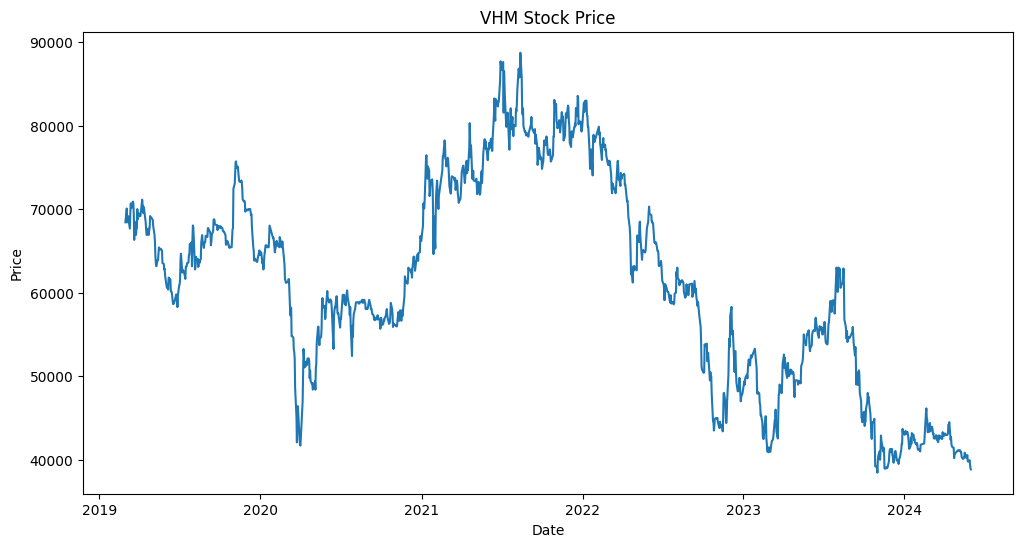

In [3]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df['Price'])
plt.title('VHM Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

#### Ratio 7:3

In [5]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [6]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 0.2235
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0218
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0113
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0085
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0063
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0049
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0046
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0042
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0038
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0044
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0041
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0040
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0040
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0040
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1649.504320668362
Testing MAPE: 0.029144306172682124
Testing MAE: 1323.6544501919798


In [14]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


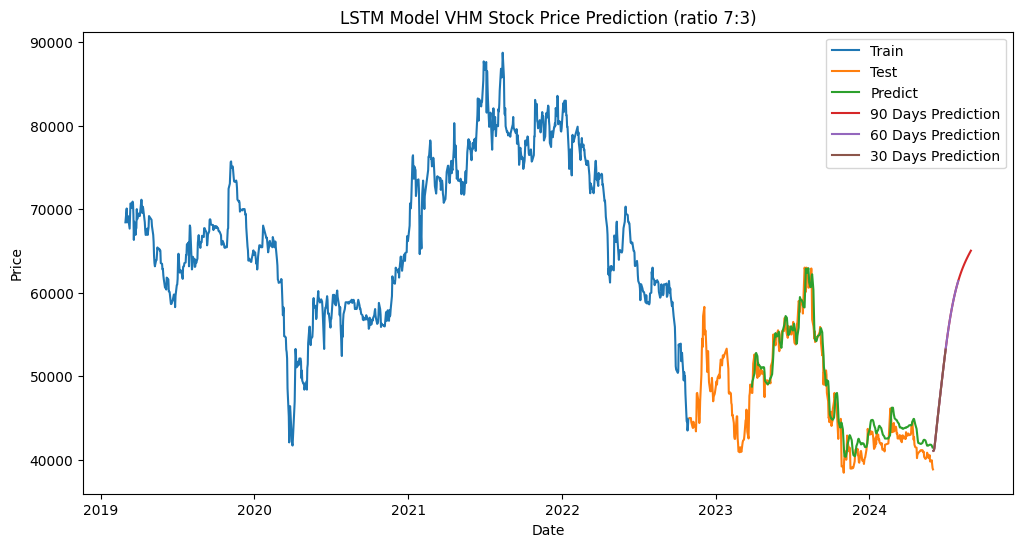

In [15]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model VHM Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Ratio 8:2

In [16]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [17]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [18]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [19]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [20]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 0.1486
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0169
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0080
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0061
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0052
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0051
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0046
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0047
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0041
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.0042
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0043
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0043
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0042
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0040
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s

In [22]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [23]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred.reshape(-1,1))

In [24]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1569.9725062099997
Testing MAPE: 0.03169899321183121
Testing MAE: 1319.1016107253085


In [25]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


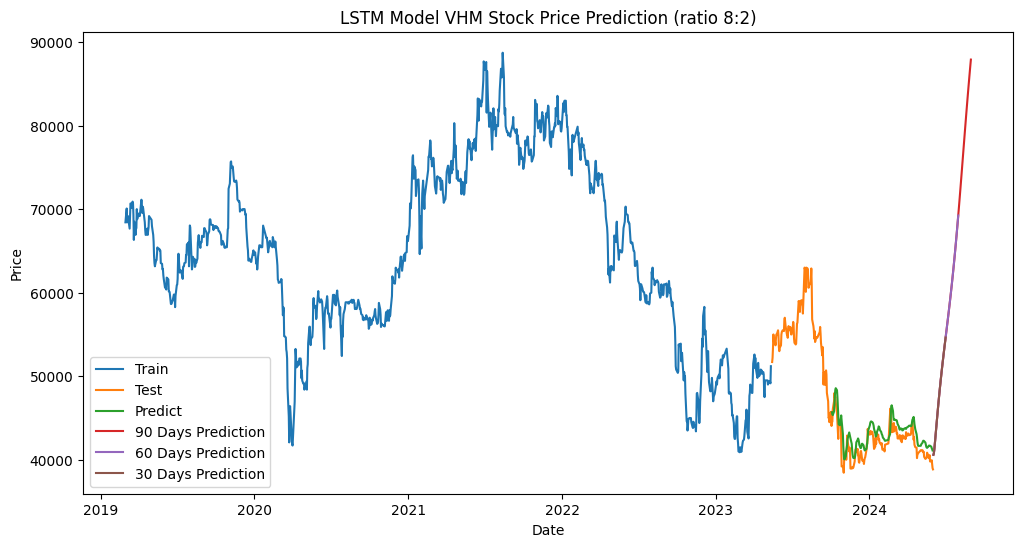

In [26]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model VHM Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Radio 9:1

In [27]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [28]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [29]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [30]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [31]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.1010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0115
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0073
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0044
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0045
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0041
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0041
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0039
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0040
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0039
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0039
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.0041
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0035
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0037
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [33]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


In [34]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [35]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 707.2017860128252
Testing MAPE: 0.0130623393335646
Testing MAE: 532.9825520833333


In [36]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


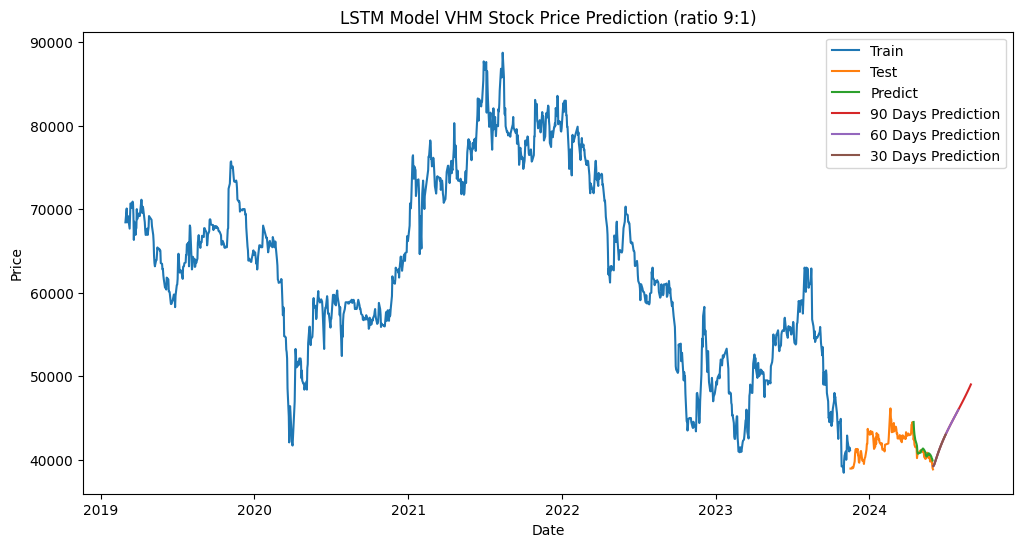

In [37]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model VHM Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

### Dataset: NVL Historical Data


In [38]:
df = pd.read_csv('../Datasets/2 - NVL Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df


,Price
Date,
2019-03-01,32933.0
2019-03-04,33100.0
2019-03-05,32711.0
2019-03-06,31709.0
2019-03-07,31932.0
...,...
2024-05-27,14500.0
2024-05-28,14500.0
2024-05-29,14150.0


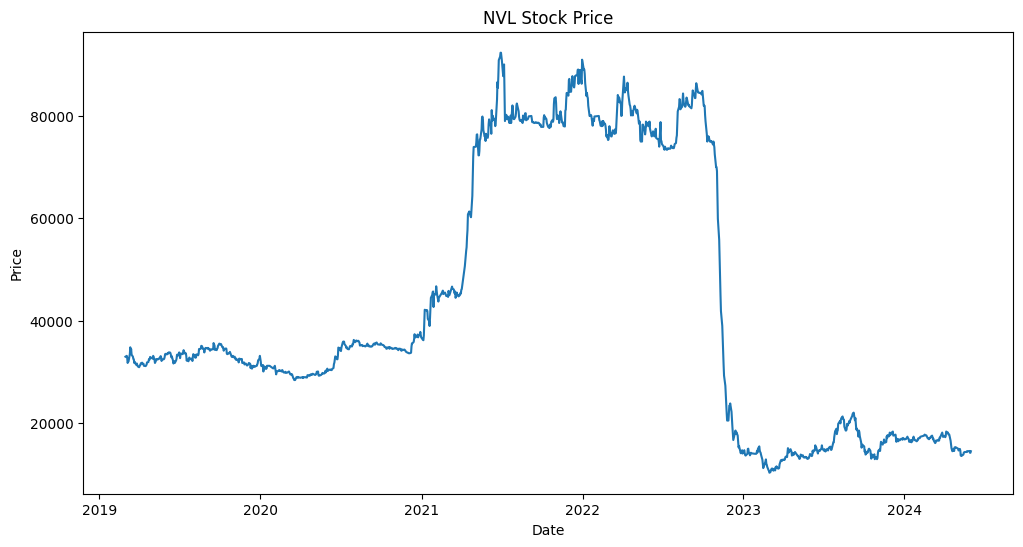

In [39]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df['Price'])
plt.title('NVL Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [40]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

#### Ratio 7:3

In [41]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [42]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [43]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [44]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [45]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.1263
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0139
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.0047
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0026
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0018
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0018
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0017
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0017
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0018
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0019
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0016
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0013
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0015
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0014
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [47]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [48]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [49]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 2168.7866604015976
Testing MAPE: 0.1229609979913312
Testing MAE: 1948.1605095456484


In [50]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


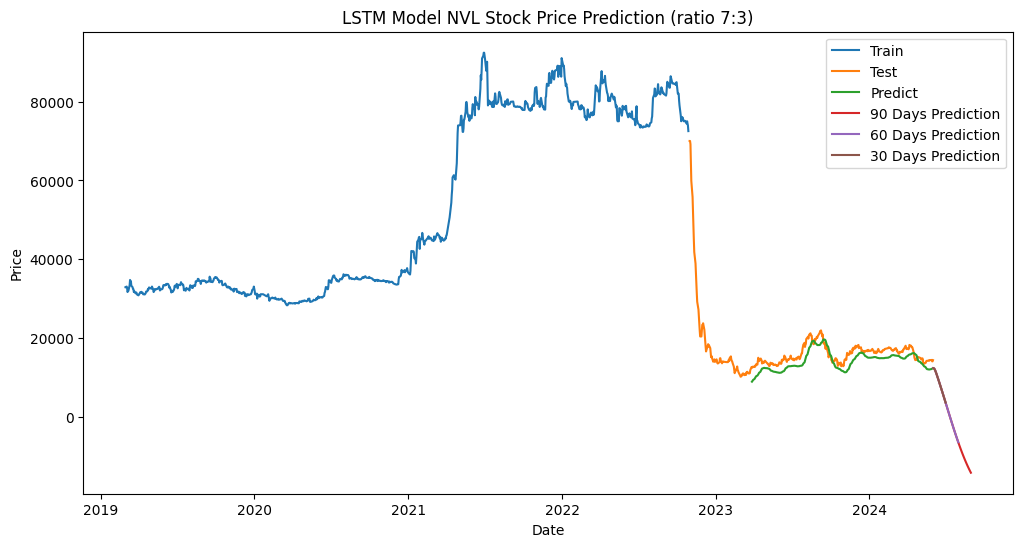

In [51]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NVL Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Ratio 8:2

In [52]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [53]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [54]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [55]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [56]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [57]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 0.1991
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0206
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0062
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0045
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0035
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.0031
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0028
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0023
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0025
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.0022
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.0018
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0019
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0016
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.0017
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [58]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


In [59]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [60]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 747.3265641458131
Testing MAPE: 0.03569316493938043
Testing MAE: 565.9315321180555


In [61]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


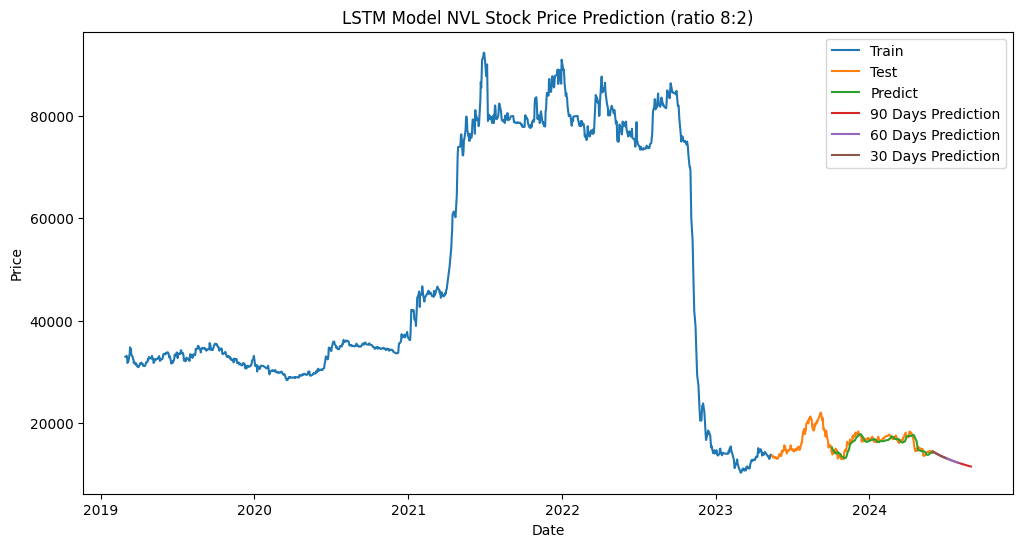

In [62]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NVL Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Radio 9:1

In [63]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [64]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [65]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [66]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [67]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [68]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.1696
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0159
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0047
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0045
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0037
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0033
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0028
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.0025
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0021
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0018
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0015
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0019
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0017
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0013
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [69]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


In [70]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [71]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 920.2406068965706
Testing MAPE: 0.047400945561607934
Testing MAE: 695.4968424479167


In [72]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


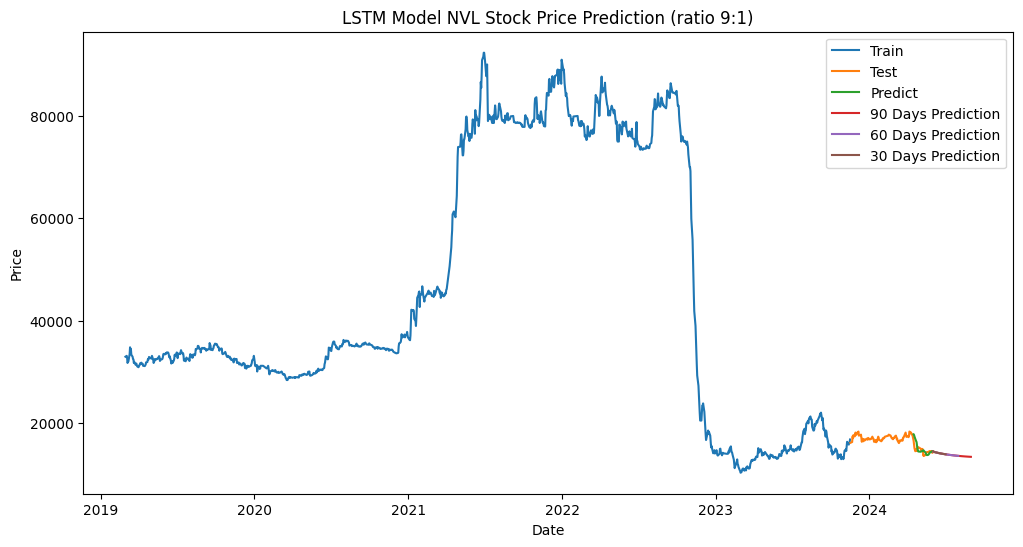

In [73]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NVL Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

### Dataset: NLG Historical Data


In [74]:
df = pd.read_csv('../Datasets/3 - NLG Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df


,Price
Date,
2019-03-01,18706.8
2019-03-04,19127.2
2019-03-05,18917.0
2019-03-06,18846.9
2019-03-07,18706.8
...,...
2024-05-27,43900.0
2024-05-28,43701.0
2024-05-29,44400.0


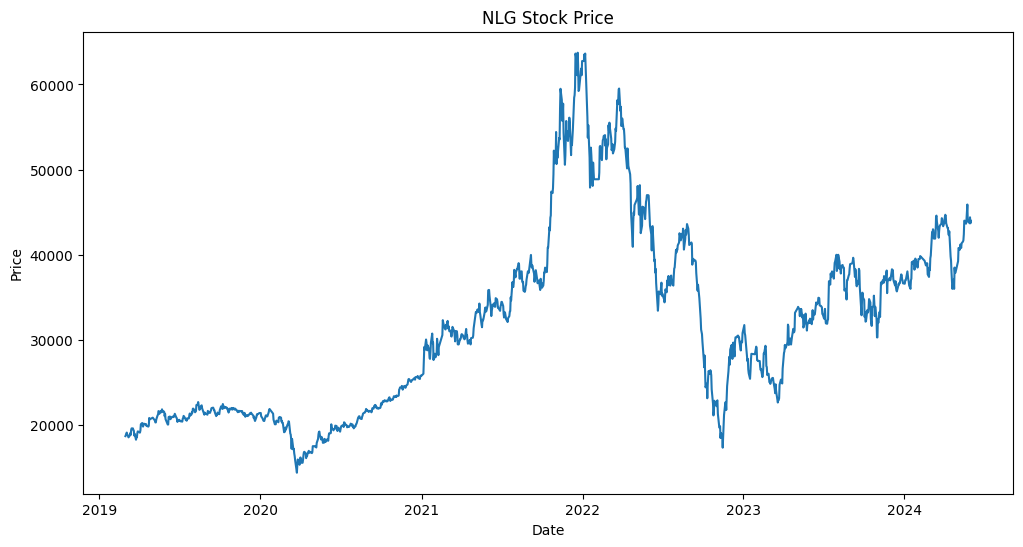

In [75]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df['Price'])
plt.title('NLG Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [76]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

#### Ratio 7:3

In [77]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [78]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [79]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [80]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [81]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [82]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 236ms/step - loss: 0.0852
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 0.0143
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 0.0053
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - loss: 0.0037
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - loss: 0.0035
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0034
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0029
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0028
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0025
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0026
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0025
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0022
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0021
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0020
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s

In [83]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [84]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [85]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1213.7439771067602
Testing MAPE: 0.025765738345911966
Testing MAE: 923.5768184726962


In [86]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


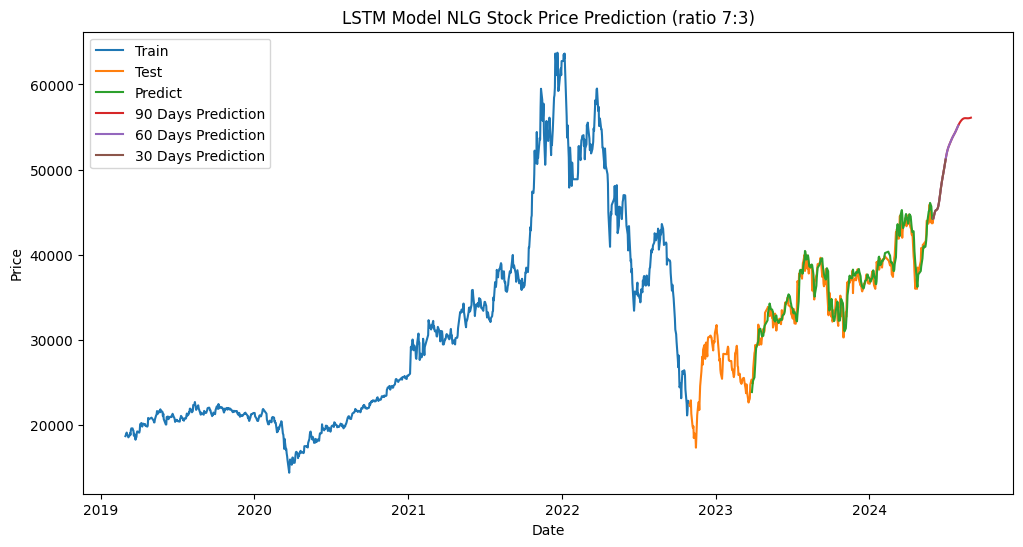

In [87]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NLG Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Ratio 8:2

In [88]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [89]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [90]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [91]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [92]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [93]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 194ms/step - loss: 0.0589
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0078
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0040
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0037
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0031
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.0032
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0028
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0027
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0023
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.0023
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.0021
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0021
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0019
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0018
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s

In [94]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [95]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [96]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1193.5641341153653
Testing MAPE: 0.024828307340867727
Testing MAE: 936.9438777970679


In [97]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


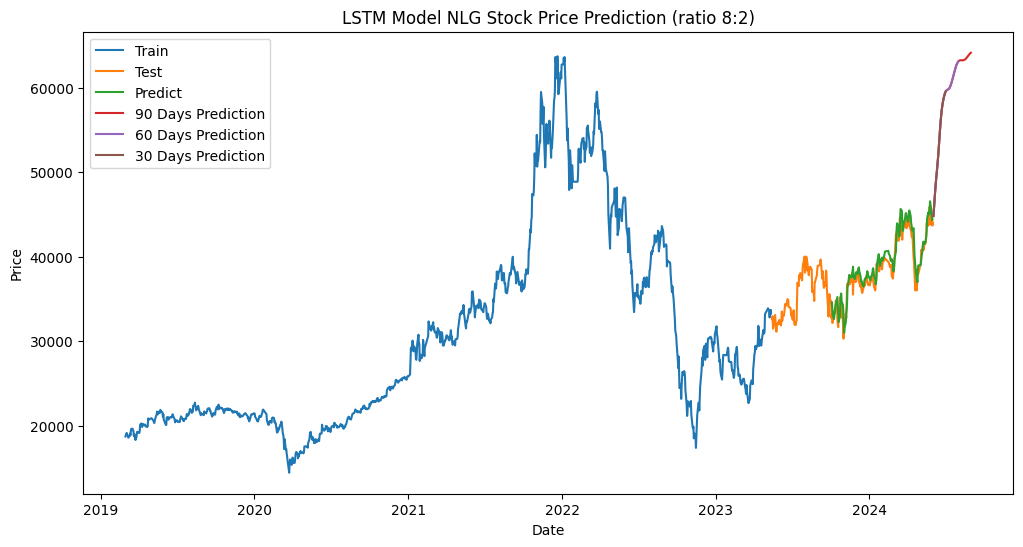

In [98]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NLG Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Radio 9:1

In [99]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [100]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [101]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [102]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [103]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [104]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.0909
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.0070
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 0.0038
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 0.0037
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0034
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - loss: 0.0029
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - loss: 0.0030
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - loss: 0.0028
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - loss: 0.0023
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - loss: 0.0021
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - loss: 0.0020
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - loss: 0.0020
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - loss: 0.0020
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.0021
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [105]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


In [106]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [107]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1193.0892416756565
Testing MAPE: 0.0227632248183145
Testing MAE: 921.9087239583333


In [108]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


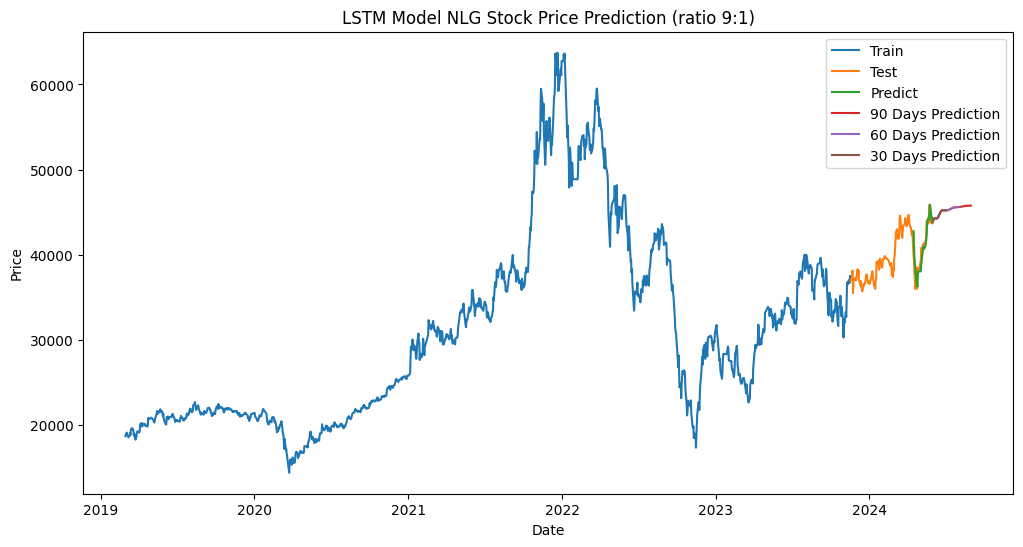

In [109]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NLG Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()